In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph

from commonen import h5dataset, traininer, onnxexporter

class JassPlayDNN(nn.Module):
    def __init__(self, num_inputs=72, hidden_sizes=[512, 256, 128]):
        super(JassPlayDNN, self).__init__()
        layers = []
        in_dim = num_inputs * 37
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        self.hidden = nn.Sequential(*layers)
        self.policy_head = nn.Linear(in_dim, 9)

    def forward(self, state_idx):
        one_hot = F.one_hot(state_idx, num_classes=37).float()
        one_hot = one_hot.view(one_hot.size(0), -1) # Flatten the input
        x = self.hidden(one_hot)
        logits = self.policy_head(x)
        policy = F.log_softmax(logits, dim=1)
        return policy

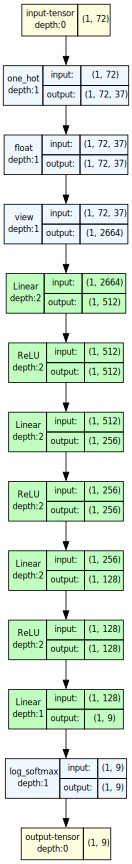

In [ ]:
# Plot model graph
model = JassPlayDNN()
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)
model_graph.visual_graph

In [2]:

DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
MODLE_PATH = './models/jass_play_dnn.pth'
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Initialize model, optimizer, and loss function
model = JassPlayDNN().to(device)
model_graph = draw_graph(model, torch.zeros(1, 72).long().to(device), show_shapes=True)
model_graph.visual_graph()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
traininer = traininer.Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=F.nll_loss,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cpu


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../log_parser/dataset/flat_playing.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
# train the model
traininer.train(NUM_EPOCHS)

Validation Epoch 1: 100%|██████████| 17334/17334 [00:52<00:00, 330.01it/s]


Epoch 1/10 - Train Loss: 0.7370, Train Accuracy: 0.6908, Val Loss: 0.6540, Val Accuracy: 0.7287
Model saved at epoch 1 with validation loss 0.6540


Validation Epoch 2: 100%|██████████| 17334/17334 [00:52<00:00, 328.29it/s]


Epoch 2/10 - Train Loss: 0.6294, Train Accuracy: 0.7407, Val Loss: 0.6154, Val Accuracy: 0.7475
Model saved at epoch 2 with validation loss 0.6154


Validation Epoch 3: 100%|██████████| 17334/17334 [00:51<00:00, 334.43it/s]


Epoch 3/10 - Train Loss: 0.5987, Train Accuracy: 0.7555, Val Loss: 0.5954, Val Accuracy: 0.7571
Model saved at epoch 3 with validation loss 0.5954


Validation Epoch 4: 100%|██████████| 17334/17334 [00:51<00:00, 333.75it/s]


Epoch 4/10 - Train Loss: 0.5835, Train Accuracy: 0.7627, Val Loss: 0.5863, Val Accuracy: 0.7615
Model saved at epoch 4 with validation loss 0.5863


Validation Epoch 5: 100%|██████████| 17334/17334 [00:52<00:00, 327.63it/s]


Epoch 5/10 - Train Loss: 0.5748, Train Accuracy: 0.7666, Val Loss: 0.5814, Val Accuracy: 0.7636
Model saved at epoch 5 with validation loss 0.5814


Validation Epoch 6: 100%|██████████| 17334/17334 [00:53<00:00, 326.66it/s]


Epoch 6/10 - Train Loss: 0.5687, Train Accuracy: 0.7696, Val Loss: 0.5788, Val Accuracy: 0.7655
Model saved at epoch 6 with validation loss 0.5788


Validation Epoch 7: 100%|██████████| 17334/17334 [00:53<00:00, 326.49it/s]


Epoch 7/10 - Train Loss: 0.5642, Train Accuracy: 0.7717, Val Loss: 0.5754, Val Accuracy: 0.7669
Model saved at epoch 7 with validation loss 0.5754


Validation Epoch 8: 100%|██████████| 17334/17334 [01:02<00:00, 277.33it/s]


Epoch 8/10 - Train Loss: 0.5607, Train Accuracy: 0.7733, Val Loss: 0.5714, Val Accuracy: 0.7688
Model saved at epoch 8 with validation loss 0.5714


Validation Epoch 9: 100%|██████████| 17334/17334 [01:01<00:00, 283.66it/s]


Epoch 9/10 - Train Loss: 0.5579, Train Accuracy: 0.7748, Val Loss: 0.5740, Val Accuracy: 0.7680


Validation Epoch 10: 100%|██████████| 17334/17334 [00:52<00:00, 327.77it/s]

Epoch 10/10 - Train Loss: 0.5556, Train Accuracy: 0.7759, Val Loss: 0.5716, Val Accuracy: 0.7699


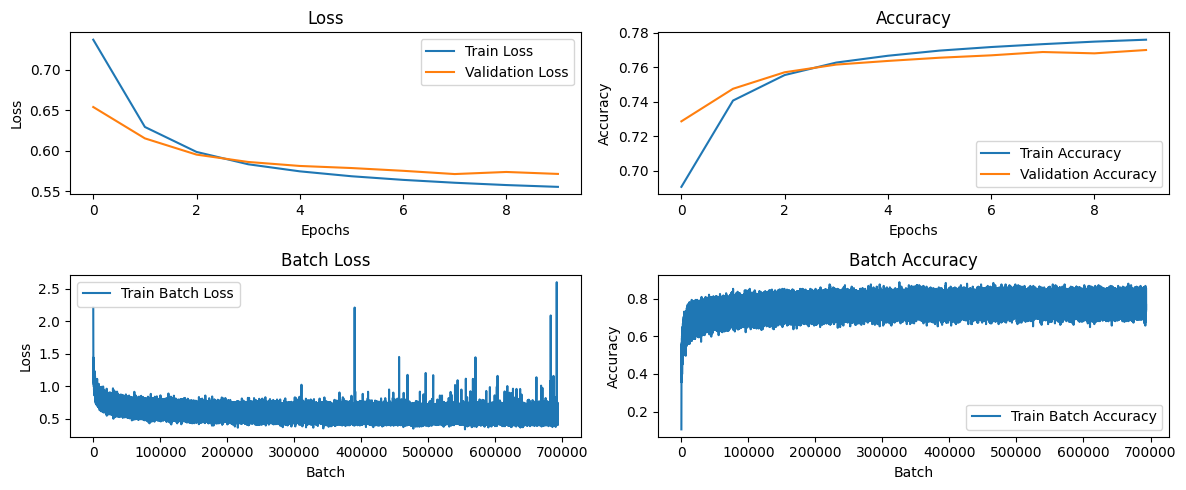

In [4]:
# create graphs
traininer.monitor.plot()

In [3]:
# export the model to ONNX
ONNX_PATH = './onnx/jass_play_dnn.onnx'
model = JassPlayDNN() # Reinitialize the model for export on CPU
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    model_path=MODLE_PATH,
    output_path=ONNX_PATH
)

Successfully loaded trained model state dictionary from ./models/jass_play_dnn.pth
Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./onnx/jass_play_dnn.onnx
